In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anime-faces/data/21130.png
/kaggle/input/anime-faces/data/9273.png
/kaggle/input/anime-faces/data/18966.png
/kaggle/input/anime-faces/data/14127.png
/kaggle/input/anime-faces/data/18054.png
/kaggle/input/anime-faces/data/9292.png
/kaggle/input/anime-faces/data/11396.png
/kaggle/input/anime-faces/data/14260.png
/kaggle/input/anime-faces/data/4353.png
/kaggle/input/anime-faces/data/7968.png
/kaggle/input/anime-faces/data/15834.png
/kaggle/input/anime-faces/data/6490.png
/kaggle/input/anime-faces/data/5511.png
/kaggle/input/anime-faces/data/6262.png
/kaggle/input/anime-faces/data/2664.png
/kaggle/input/anime-faces/data/12329.png
/kaggle/input/anime-faces/data/17678.png
/kaggle/input/anime-faces/data/8419.png
/kaggle/input/anime-faces/data/9703.png
/kaggle/input/anime-faces/data/13412.png
/kaggle/input/anime-faces/data/14325.png
/kaggle/input/anime-faces/data/18315.png
/kaggle/input/anime-faces/data/15055.png
/kaggle/input/anime-faces/data/2539.png
/kaggle/input/anime-faces/d

<H1 style="color:gold;font:Helvetica;text-align:center">Introduction</H1><a id="1"></a>
<p style="font-size:15px">This kernel is meant as an introduction to generating anime characters or using GANS for Deepfake in general. We will first generate handwritten digits by using the classic MNIST dataset and in doing so we will create some useful helper functions then we will just make changes in our GAN architecture and use it to generate anime characters and in the last, with the help of transfer learning we will use a pre-trained model on StyleGan2
to generate realistic looking  anime Deepfakes

In short<br>
<b>we will go from generating this</b>
    <img src="https://storage.googleapis.com/tfds-data/visualization/fig/mnist-3.0.1.png"><br>
    <p><b>to this</b><br></p>
    <img src="https://raw.githubusercontent.com/STomoya/animeface/master/implementations/StyleGAN2/result/118000.png"><br>

</p>


# Table of content
* [<font size=4>Introduction</font>](#1)
* [<font size=4>Generative adversarial network</font>](#2)
* [<font size=4>MNIST DeepFake</font>](#3)
   * [<font size=4>Data Preprocessing</font>](#3.1)
   * [<font size=4>Model</font>](#3.2)
   * [<font size=4>Helper Functions</font>](#3.3)
   * [<font size=4>Results</font>](#3.4)
* [<font size=4>Anime DeepFake</font>](#4)
   * [<font size=4>Data Preprocessing</font>](#4.1)
   * [<font size=4>Model</font>](#4.2)
   * [<font size=4>Results</font>](#4.3)
* [<font size=4>Conclusion</font>](#5)

<H1 style="color:gold;font:Helvetica;text-align:center">Generative Adversarial Network</H1><a id="2"></a>
<p style="font-size:15px">The Generative adversarial network is a class of machine learning framework designed by Ian Goodfellow in 2014 in which two neural networks (Generator and Discriminator) compete with each other in a zero-sum game meaning gain in performance of one network is at cost of other network.<br><img src ="https://miro.medium.com/max/846/1*rdXKdyfNjorzP10ZA3yNmQ.png"><br> The generator takes a noice vector from some distribution  and outputs an image while Discriminator classify between real and fake images
In this kernel, we will see the implementation of DCGAN which is a special type of Generative adversarial network which uses Convolutional neural networks</p>

<H1 style="color:gold;font:Helvetica;text-align:center" id="mnist">MNIST DeepFake</H1><a id="3"></a>

<H1 style="color:gold;font:Helvetica;text-align:center">Preparing Dataset</H1><a id="3.1"></a>

<div style="font-size:15px">Importing necessary libraries</div>

In [2]:
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import keras.layers as L

In [3]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [5]:
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256)

<H1 style="color:gold;font:Helvetica;text-align:center">Model</H1><a id="3.2"></a>

<div style="font-size:15px">discriminator will take a batch_sizex28x28x1 shape image and will return 1x1 output, positive for real image and negative value for a fake image</div>

In [6]:
discriminator = tf.keras.Sequential()
discriminator.add(L.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1]))
discriminator.add(L.LeakyReLU())
discriminator.add(L.Dropout(0.3))
discriminator.add(L.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(L.LeakyReLU())
discriminator.add(L.Dropout(0.3))
discriminator.add(L.Flatten())
discriminator.add(L.Dense(1))

<div style="font-size:15px">the generator will take noice vector of shape  None x 100 and return different images of shape None x 28 x 28 x 1</div>

In [7]:
generator = tf.keras.Sequential()
generator.add(L.Dense(7*7*256, use_bias=False, input_shape=(100,)))
generator.add(L.BatchNormalization())
generator.add(L.LeakyReLU())
generator.add(L.Reshape((7, 7, 256)))
generator.add(L.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
generator.add(L.BatchNormalization())
generator.add(L.LeakyReLU())
generator.add(L.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
generator.add(L.BatchNormalization())
generator.add(L.LeakyReLU())
generator.add(L.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

<H1 style="color:gold;font:Helvetica;text-align:center">Helper Functions</H1><a id="3.3"></a>

<div style="font-size:15px">reusable helper functions for training GAN that can be used on any dataset</div>

In [8]:
loss = keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
def discriminator_loss(real,fake):
  real_loss = loss(tf.ones_like(real),real)
  fake_loss = loss(tf.zeros_like(fake),fake)
  return real_loss + fake_loss

In [10]:
def generator_loss(fake):
  gen_loss = loss(tf.ones_like(fake),fake)
  return gen_loss

In [11]:
generator_optimizer = keras.optimizers.Adam(0.0002,0.5)
discriminator_optimizer = keras.optimizers.Adam(0.0002,0.5)

In [12]:
@tf.function
def train_step(images):
    noise = tf.random.normal([256,100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss,disc_loss

In [13]:
def train(dataset, epochs):
  gen_loss=0
  dis_loss=0
  gen_plot = []
  dis_plot = []
  for epoch in range(epochs):
    print(f'{epoch+1} of {epochs}',end = ' ')
    print(f'generator loss is {gen_loss} and discriminator loss is {dis_loss}')
    for image_batch in dataset: 
      gen_loss,dis_loss = train_step(image_batch)
    gen_plot.append(gen_loss)
    dis_plot.append(dis_loss)
  x = [X for X in range(epochs)]
  plt.plot(x,gen_plot)
  plt.plot(x,dis_plot)
  plt.title('epoch vs loss')
  plt.legend(['gen_loss','dis_loss'])
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.show()

In [14]:
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)


1 of 25 generator loss is 0 and discriminator loss is 0
2 of 25 generator loss is 0.759095311164856 and discriminator loss is 1.2654169797897339
3 of 25 generator loss is 0.8351965546607971 and discriminator loss is 1.343621015548706
4 of 25 generator loss is 0.7423991560935974 and discriminator loss is 1.2579643726348877
5 of 25 generator loss is 0.7682149410247803 and discriminator loss is 1.2969790697097778
6 of 25 generator loss is 0.9248538017272949 and discriminator loss is 1.4435932636260986
7 of 25 generator loss is 0.7122109532356262 and discriminator loss is 1.3422915935516357
8 of 25 generator loss is 0.9408727884292603 and discriminator loss is 1.1811127662658691
9 of 25 generator loss is 0.5604125261306763 and discriminator loss is 1.4351377487182617
10 of 25 generator loss is 1.071526288986206 and discriminator loss is 1.3556065559387207
11 of 25 generator loss is 0.5877624750137329 and discriminator loss is 1.3723957538604736
12 of 25 generator loss is 0.7587050199508667

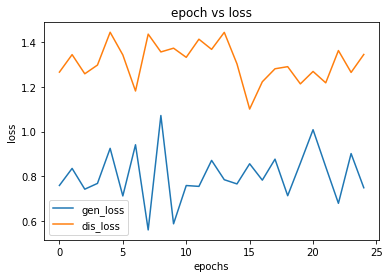

In [15]:
train(dataset,25)

In [16]:
noice = np.random.randn(32,100)
pred = generator.predict(noice)

<H1 style="color:gold;font:Helvetica;text-align:center">Results</H1><a id="3.4"></a>

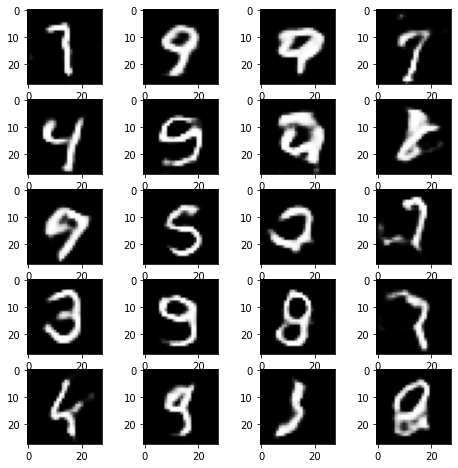

In [17]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(pred[i],cmap='gray')
plt.show()

<H1 style="color:gold;font:Helvetica;text-align:center">Anime Deepfake</H1><a id="4"></a>

<H1 style="color:gold;font:Helvetica;text-align:center">Preparing Dataset</H1><a id="4.1"></a>

In [18]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '../input/anime-faces/data/', label_mode=None, image_size=(64,64),batch_size=128
)
dataset = dataset.map(lambda x: (x / 127.5) - 1)

Found 21551 files belonging to 1 classes.


(64, 64, 3)
128


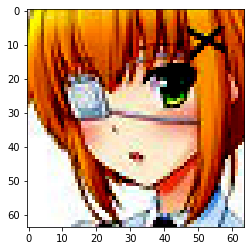

In [19]:
for batch in dataset:
    plt.imshow(batch[0])
    print(batch[0].shape)
    print(len(batch))
    break

<H1 style="color:gold;font:Helvetica;text-align:center">Model</H1><a id="4.2"></a>

<div style="font-size:15px">the generator will take noice vector of shape  None x 100 and return different images of shape None x 64 x 64 x 3</div>

In [20]:
code_size = 100
batch_size = 128
generator = keras.Sequential()
generator.add(L.Input(shape=(100,)))
generator.add(L.Dense(4*4*256))
generator.add(L.BatchNormalization())
generator.add(L.ReLU())
generator.add(L.Reshape((4,4,256)))
generator.add(L.Conv2DTranspose(128,kernel_size=4,padding='same',strides=2))
generator.add(L.BatchNormalization())
generator.add(L.ReLU())
generator.add(L.Conv2DTranspose(64,kernel_size=4,padding='same',strides=2))
generator.add(L.BatchNormalization())
generator.add(L.ReLU())
generator.add(L.Conv2DTranspose(32,kernel_size=4,padding='same',strides=2))
generator.add(L.BatchNormalization())
generator.add(L.ReLU())
generator.add(L.Conv2DTranspose(3,kernel_size=4,padding='same',strides=2))
generator.add(L.Activation('tanh'))

In [21]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              413696    
_________________________________________________________________
batch_normalization_3 (Batch (None, 4096)              16384     
_________________________________________________________________
re_lu (ReLU)                 (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         524416    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 8, 128)        

<div style="font-size:15px">the generator will take noice vector of shape  None x 100 and return different images of shape None x 28 x 28 x 1</div>

In [22]:
image_shape = (64,64,3)
discriminator = keras.Sequential()
discriminator.add(L.Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
discriminator.add(L.LeakyReLU(alpha=0.2))
discriminator.add(L.Dropout(0.25))
discriminator.add(L.Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(L.ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(L.BatchNormalization(momentum=0.8))
discriminator.add(L.LeakyReLU(alpha=0.2))
discriminator.add(L.Dropout(0.25))
discriminator.add(L.Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(L.BatchNormalization(momentum=0.8))
discriminator.add(L.LeakyReLU(alpha=0.2))
discriminator.add(L.Dropout(0.25))
discriminator.add(L.Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(L.BatchNormalization(momentum=0.8))
discriminator.add(L.LeakyReLU(alpha=0.2))
discriminator.add(L.Dropout(0.25))
discriminator.add(L.Flatten())
discriminator.add(L.Dense(1))

In [23]:
@tf.function
def train_step(images):
    noise = tf.random.normal([256,100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss,disc_loss

1 of 20 generator loss is 0 and discriminator loss is 0
2 of 20 generator loss is 2.113706350326538 and discriminator loss is 1.0439085960388184
3 of 20 generator loss is 0.6540505886077881 and discriminator loss is 2.451897144317627
4 of 20 generator loss is 2.0933289527893066 and discriminator loss is 0.45575642585754395
5 of 20 generator loss is 1.7067804336547852 and discriminator loss is 0.6472634077072144
6 of 20 generator loss is 1.3107881546020508 and discriminator loss is 0.795695424079895
7 of 20 generator loss is 3.318554401397705 and discriminator loss is 0.8482528924942017
8 of 20 generator loss is 1.6963688135147095 and discriminator loss is 0.7915394306182861
9 of 20 generator loss is 1.798384666442871 and discriminator loss is 0.6159389615058899
10 of 20 generator loss is 1.9411203861236572 and discriminator loss is 0.7056885957717896
11 of 20 generator loss is 2.058040142059326 and discriminator loss is 0.5271869897842407
12 of 20 generator loss is 2.59244966506958 and

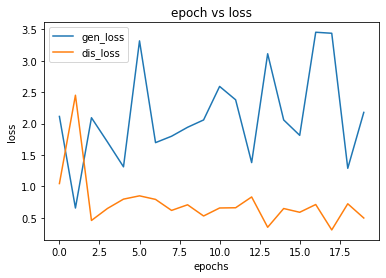

In [24]:
train(dataset,20)

In [25]:
noice = np.random.randn(32,100)
pred = generator.predict(noice)

<H1 style="color:gold;font:Helvetica;text-align:center">Result</H1><a id="4.3"></a>

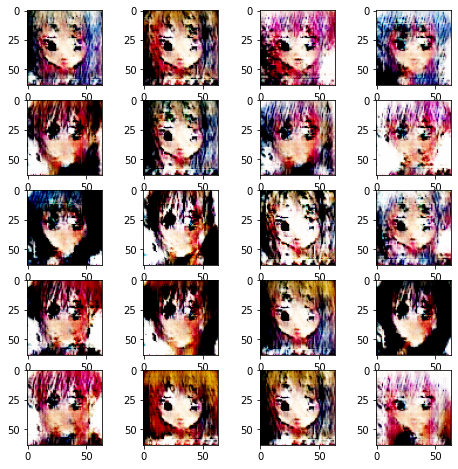

In [26]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(pred[i])
plt.show()

<div style="font-size:15px">Even though we generated anime faces but results aren't that realistic <b>Why?</b>  Because Gans are hard to train and generating anime Deepfake is even harder as it turns around even though Gans are good at generate high-quality real faces they struggle at generating anime faces and it is only recently that it has been solved mostly beacuse of StyleGan. Since officially StyleGan is only released in TensorFlow 1 and it is not possible to run 2 versions of same library running in a single kernel so I created google colab notebook to show how to how to generate realistic-looking images of anime characters using StyleGan 2 which can be found <a href="https://colab.research.google.com/drive/1PHRo_n6QPSQpUfnnDSfzNCswjACimlmA?usp=sharing">here</a><br><b>Example Output:-</b></div>
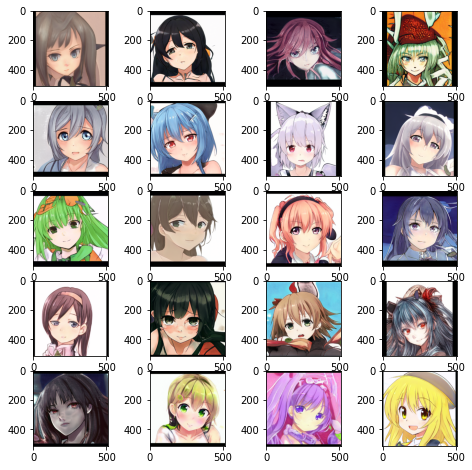

<H1 style="color:gold;font:Helvetica;text-align:center">Conclusion</H1><a id="5"></a>
<p style="font-size:15px">In this kernel, we saw how can we make a simple DCGAN generate MNIST DeepFake then we reused most of the same code with modification in only DCGAN architecture to generate anime faces and in the end used pretrained StyleGan model to generate realistic looking Anime DeepFake</p>

<H1 style="color:gold;font:Helvetica;text-align:center">Thank You</H1>